In [1]:
# %% [markdown]
# # 1. Import Libraries
# 
# Import all necessary libraries for data processing, modeling, and explainability.

# %% [python]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

In [2]:


# Scikit-learn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:

# TensorFlow and Keras for the Neural Network
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# A (recommended) alternative model
from sklearn.ensemble import RandomForestRegressor

2025-10-30 14:19:17.941542: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 14:19:17.998725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 14:19:19.258628: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress minor warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"SHAP Version: {shap.__version__}")
print("Libraries loaded successfully.")

TensorFlow Version: 2.20.0
SHAP Version: 0.49.1
Libraries loaded successfully.


# %% [markdown]
# # 2. Load and Clean Data
# 
# This section assumes the 10,000-row file has the same structure as the sample.
# 1. Load the data (assuming the file is named "kredo2.xlsx - Sheet2.csv").
# 2. Drop all completely empty rows (if any).
# 3. Drop columns that are not useful (like `farmer_id` or the formula-like column).
# 4. Convert all numerical columns from text to numbers.
# 5. Parse the `location` column into `latitude` and `longitude`.

In [5]:

# %% [python]
# --- IMPORTANT ---
# Update this filename if your 10,000-row file has a different name
FILE_NAME = "kilimodata10k.csv"

# Load the dataset
try:
    # df = pd.read_csv(FILE_NAME)
    # df = pd.read_csv(FILE_NAME, encoding='latin1')
    # df = pd.read_csv(FILE_NAME, encoding='latin1', engine='python')
    df = pd.read_csv(FILE_NAME)
    print(f"Successfully loaded {FILE_NAME}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found: {FILE_NAME}")
    # Create dummy data to allow the rest of the notebook to run
    # In your real run, you would stop here.
    # df = pd.DataFrame(np.random.rand(100, 17), columns=['farmer_id', 'location', 'NDVI', 'avg_rainfall', 'avg_temp', 'crop_type', 'price_of_crop', 'farm_size_in_squire_meter', 'previous_loans_count', 'defaulted_loans_count', 'crop_yeild_per_squiremeter', 'total_yield(ksh)=H2K2G2', 'seasonal_expense', 'credict_score', 'interest_rate', 'loan_limit', 'loan_duration'])
    # df['location'] = df['location'].apply(lambda x: f"{-x},{x*30}")
    # df['crop_type'] = np.random.choice(['Maize', 'Tea', 'Coffee'], size=100)

Successfully loaded kilimodata10k.csv. Shape: (10000, 17)


In [6]:
# %% [markdown]
# # 2. Load, Clean, and Engineer Features
# 
# This is the most critical step. We are engineering new
# features to measure risk, profitability, and efficiency.

# %% [python]
import pandas as pd
import numpy as np

# --- 1. Load Data ---
FILE_NAME = "kilimodata10k.csv"
try:
    # Try reading as Excel first, as the original name was .xlsx
    df = pd.read_csv(FILE_NAME)
    print(f"Successfully loaded Excel file: {FILE_NAME}. Shape: {df.shape}")
except Exception as e_excel:
    print(f"Failed to read as Excel ({e_excel}), trying CSV...")
    try:
        df = pd.read_csv(FILE_NAME, encoding='latin1', engine='python')
        print(f"Successfully loaded CSV file: {FILE_NAME}. Shape: {df.shape}")
    except Exception as e_csv:
        print(f"Failed to read as CSV ({e_csv}). Please check the file.")
        raise e_csv

# --- 2. Basic Cleaning ---
df.dropna(how='all', inplace=True)

# Drop identifier/junk columns
if 'farmer_id' in df.columns:
    df.drop(columns=['farmer_id'], inplace=True)
    
# RENAME columns to be consistent
# Fix the typo 'sesional_expense' and the complex total_yield name
df.rename(columns={
    'sesional_expense': 'seasonal_expense',
    'total_yield(ksh)': 'total_yield_ksh',
    'farm_size_in_squire_meter': 'farm_size_sqm',
    'crop_yeild_per_squiremeter': 'crop_yield_per_sqm'
}, inplace=True)

# Define target columns (for later)
target_cols = ['credict_score', 'interest_rate', 'loan_limit', 'loan_duration']

# Convert all columns (except location/crop_type) to numeric
all_cols = df.columns.tolist()
numeric_cols_to_convert = [col for col in all_cols if col not in ['location', 'crop_type']]
for col in numeric_cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# --- 3. Advanced Feature Engineering ---
print("Engineering new features...")

# A) Profitability & Efficiency Features (VERY IMPORTANT)
df['net_income'] = df['total_yield_ksh'] - df['seasonal_expense']
df['profit_margin'] = df['net_income'] / (df['total_yield_ksh'] + 1e-6)
df['expense_ratio'] = df['seasonal_expense'] / (df['total_yield_ksh'] + 1e-6)
df['yield_value_per_sqm'] = df['total_yield_ksh'] / (df['farm_size_sqm'] + 1e-6)
df['expense_per_sqm'] = df['seasonal_expense'] / (df['farm_size_sqm'] + 1e-6)
df['loan_duration'] = df['loan_duration'] * 30
df['interest_rate'] = df['interest_rate'] * 100

# B) Risk Features (VERY IMPORTANT)
# Create a robust 'default_rate'. Handle division by zero.
df['default_rate'] = df['defaulted_loans_count'] / (df['previous_loans_count'] + 1e-6)
# Penalize farmers with 0 previous loans but 1 default (if possible)
df.loc[df['previous_loans_count'] == 0, 'default_rate'] = df.loc[df['previous_loans_count'] == 0, 'defaulted_loans_count'].apply(lambda x: 1 if x > 0 else 0)

# C) Geographic Features
try:
    df['location_cleaned'] = df['location'].str.replace('"', '')
    df[['latitude', 'longitude']] = df['location_cleaned'].str.split(',', expand=True).astype(float)
    df.drop(columns=['location', 'location_cleaned'], inplace=True)
    print("...Location parsed successfully.")
except Exception:
    print("...Could not parse location. Dropping column.")
    if 'location' in df.columns:
        df.drop(columns=['location'], inplace=True)

# D) Agronomic Features (Interaction Terms)
if 'NDVI' in df.columns and 'avg_rainfall' in df.columns:
    df['ndvi_x_rainfall'] = df['NDVI'] * df['avg_rainfall']
if 'avg_temp' in df.columns and 'avg_rainfall' in df.columns:
    df['temp_x_rainfall'] = df['avg_temp'] * df['avg_rainfall']
if 'price_of_crop' in df.columns and 'crop_yield_per_sqm' in df.columns:
    df['price_x_yield'] = df['price_of_crop'] * df['crop_yield_per_sqm']

# --- 4. Final Cleanup ---
# Drop any rows that failed conversion
df.dropna(inplace=True)
# Ensure we don't have infinite values from division
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print(f"\nCleaned data shape with new features: {df.shape}")
print("\nCleaned Data Info:")
df.info()

Successfully loaded Excel file: kilimodata10k.csv. Shape: (10000, 17)
Engineering new features...
...Location parsed successfully.

Cleaned data shape with new features: (10000, 26)

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NDVI                   10000 non-null  float64
 1   avg_rainfall           10000 non-null  int64  
 2   avg_temp               10000 non-null  float64
 3   crop_type              10000 non-null  object 
 4   price_of_crop          10000 non-null  int64  
 5   farm_size_sqm          10000 non-null  int64  
 6   previous_loans_count   10000 non-null  int64  
 7   defaulted_loans_count  10000 non-null  int64  
 8   crop_yield_per_sqm     10000 non-null  float64
 9   total_yield_ksh        10000 non-null  float64
 10  seasonal_expense       10000 non-null  int64  
 11  credict_s

# %% [markdown]
# # 3. Define Features (X) and Targets (y)
# 
# We split the data into our input features (X) and the four target variables (y).

In [7]:
# %% [markdown]
# # 4. Create Preprocessing Pipeline
# 
# **UPDATED CELL:** This code now *automatically* finds all numerical
# and categorical features from your DataFrame. This ensures that
# all your new engineered features are correctly scaled and
# used by the model.

# %% [python]
# 1. Define features (X) and targets (y)
target_cols = ['credict_score', 'interest_rate', 'loan_limit', 'loan_duration']
features = [col for col in df.columns if col not in target_cols]

X = df[features]
y = df[target_cols]

# 2. Identify numerical and categorical features
# This is now dynamic, so it will catch all your new features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"--- Features Found ---")
print(f"Found {len(numerical_features)} numerical features: {numerical_features}")
print(f"Found {len(categorical_features)} categorical features: {categorical_features}")

# 3. Create the preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("\nPreprocessing pipeline created successfully.")

--- Features Found ---
Found 21 numerical features: ['NDVI', 'avg_rainfall', 'avg_temp', 'price_of_crop', 'farm_size_sqm', 'previous_loans_count', 'defaulted_loans_count', 'crop_yield_per_sqm', 'total_yield_ksh', 'seasonal_expense', 'net_income', 'profit_margin', 'expense_ratio', 'yield_value_per_sqm', 'expense_per_sqm', 'default_rate', 'latitude', 'longitude', 'ndvi_x_rainfall', 'temp_x_rainfall', 'price_x_yield']
Found 1 categorical features: ['crop_type']

Preprocessing pipeline created successfully.



## 4. Create Preprocessing Pipeline
# 
# We use a `ColumnTransformer` to apply `StandardScaler` to numerical features and `OneHotEncoder` to categorical features. This ensures all data is in the correct format for the neural network.


# %% [markdown]
# # 5. Train-Test Split
# 
# We split the data into training (80%) and testing (20%) sets.
# 
# The **training data** will be *further* split inside `model.fit()` to create a **validation set**.

In [8]:
# %% [python]
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}  | y_test shape: {y_test.shape}")

# Apply the preprocessing
# We fit *and* transform on the training data
X_train_processed = preprocessor.fit_transform(X_train)

# We *only* transform the test data (using the mean/scale/categories from training)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after transformation (for SHAP later)
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # Fallback for older sklearn
    feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    
print(f"\nTotal processed features: {len(feature_names)}")

X_train shape: (8000, 22) | y_train shape: (8000, 4)
X_test shape: (2000, 22)  | y_test shape: (2000, 4)

Total processed features: 33



# %% [markdown]
# # 6. Define the Multi-Head Neural Network
# 
# This architecture is designed for a large dataset ("top class" model).
# - A deep, shared "base" learns common patterns from all inputs.
# - Four separate "heads" specialize in predicting each target.
# - `BatchNormalization` and `Dropout` are used for stability and regularization.

In [9]:
from tensorflow.keras.regularizers import l2
# %% [python]
def create_multi_head_model(input_shape):
    # Input layer
    inputs = Input(shape=(input_shape,), name='main_input')
    
    # Shared base - Deeper and wider for 10,000 rows
    base = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    base = BatchNormalization()(base)
    base = Dropout(0.4)(base) # Regularization
    
    base = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(base)
    base = BatchNormalization()(base)
    base = Dropout(0.3)(base) # Regularization
    
    base = Dense(32, activation='relu')(base)
    shared_output = BatchNormalization()(base)
    
    # --- Output Heads ---
    # Each head is a mini-network branching off the shared base
    
    # Head 1: credict_score
    head_1 = Dense(32, activation='relu')(shared_output)
    output_1 = Dense(1, name='credict_score')(head_1)
    
    # Head 2: interest_rate
    head_2 = Dense(32, activation='relu')(shared_output)
    output_2 = Dense(1, name='interest_rate')(head_2)
    
    # Head 3: loan_limit
    head_3 = Dense(32, activation='relu')(shared_output)
    output_3 = Dense(1, name='loan_limit')(head_3)
    
    # Head 4: loan_duration
    head_4 = Dense(32, activation='relu')(shared_output)
    output_4 = Dense(1, name='loan_duration')(head_4)
    
    # Create the model
    model = Model(
        inputs=inputs, 
        outputs=[output_1, output_2, output_3, output_4]
    )
    
    return model

# Create the model
nn_model = create_multi_head_model(X_train_processed.shape[1])
nn_model.summary()

I0000 00:00:1761833968.617134   34191 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43710 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:d2:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      4,352 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credict_score       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ interest_rate       │ (None, 1)         │         33 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loan_limit (Dense)  │ (None, 1)         │         33 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loan_duration       │ (None, 1)         │         33 │ dense_6[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,940 (77.89 KB)

 Trainable params: 19,492 (76.14 KB)

 Non-trainable params: 448 (1.75 KB)

# %% [markdown]
# # 7. Compile and Train the Neural Network
# 
# We compile the model with:
# - `adam` optimizer (fast and efficient).
# - `mse` (Mean Squared Error) as the loss for all heads.
# - `mae` (Mean Absolute Error) as a human-readable metric.
# - `EarlyStopping`: Stops training if validation performance worsens.
# - `ReduceLROnPlateau`: Lowers the learning rate if training stalls.

In [10]:
# %% [python]
# Compile the model
nn_model.compile(
    optimizer='adam',
    loss={ # Define loss for each output head
        'credict_score': 'mse',
        'interest_rate': 'mse',
        'loan_limit': 'mse',
        'loan_duration': 'mse'
    },
    metrics={ # Define metrics for each output head
        'credict_score': 'mae',
        'interest_rate': 'mae',
        'loan_limit': 'mae',
        'loan_duration': 'mae'
    }
)

# Callbacks for better training
# Stop training if validation loss doesn't improve for 15 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
# Reduce learning rate if training plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Prepare target data for Keras (a list of arrays)
y_train_list = [y_train[col] for col in target_cols]
y_test_list = [y_test[col] for col in target_cols]

In [11]:
# --- Train the model ---
# We use validation_split=0.2
# This automatically reserves 20% of the training data (X_train_processed)
# for validation. This is the correct approach.
history = nn_model.fit(
    X_train_processed, 
    y_train_list,
    epochs=200,       # High number of epochs, EarlyStopping will find the best
    batch_size=32,    # Standard batch size
    validation_split=0.2, # Use 20% of training data for validation
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining complete.")


Epoch 1/200


2025-10-30 14:19:36.024786: I external/local_xla/xla/service/service.cc:163] XLA service 0x3e2b4880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 14:19:36.024812: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-10-30 14:19:36.113343: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 14:19:36.629798: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-30 14:19:36.858384: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 14:19:36.858500: I external/local_xla

 18/200 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - credict_score_loss: 419353.8576 - credict_score_mae: 640.6222 - interest_rate_loss: 1793254.3194 - interest_rate_mae: 1320.3896 - loan_duration_loss: 384636.5729 - loan_duration_mae: 593.9810 - loan_limit_loss: 72826950997.3333 - loan_limit_mae: 164006.4210 - loss: 72829551274.6667

I0000 00:00:1761833986.030511   34522 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - credict_score_loss: 407424.0000 - credict_score_mae: 630.7532 - interest_rate_loss: 1765784.6250 - interest_rate_mae: 1309.6241 - loan_duration_loss: 377574.8750 - loan_duration_mae: 585.0542 - loan_limit_loss: 50339237888.0000 - loan_limit_mae: 136660.3594 - loss: 50341765120.0000 - val_credict_score_loss: 369614.1562 - val_credict_score_mae: 597.5383 - val_interest_rate_loss: 1720872.6250 - val_interest_rate_mae: 1289.8536 - val_loan_duration_loss: 350823.9688 - val_loan_duration_mae: 559.6771 - val_loan_limit_loss: 45981036544.0000 - val_loan_limit_mae: 132591.2812 - val_loss: 45983490048.0000 - learning_rate: 0.0010
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - credict_score_loss: 329748.2188 - credict_score_mae: 549.9166 - interest_rate_loss: 1586307.0000 - interest_rate_mae: 1230.8408 - loan_duration_loss: 314223.5000 - loan_duration_mae: 519.0140 - loan_limit_loss: 50224390144.0000 - loan_limit_mae: 136523.8438 - loss: 50226

# %% [markdown]
# # 8. Evaluate the Neural Network
# 
# We plot the training history and evaluate the final model's performance on the **unseen test set**.


Saved nn_loss_plot.png


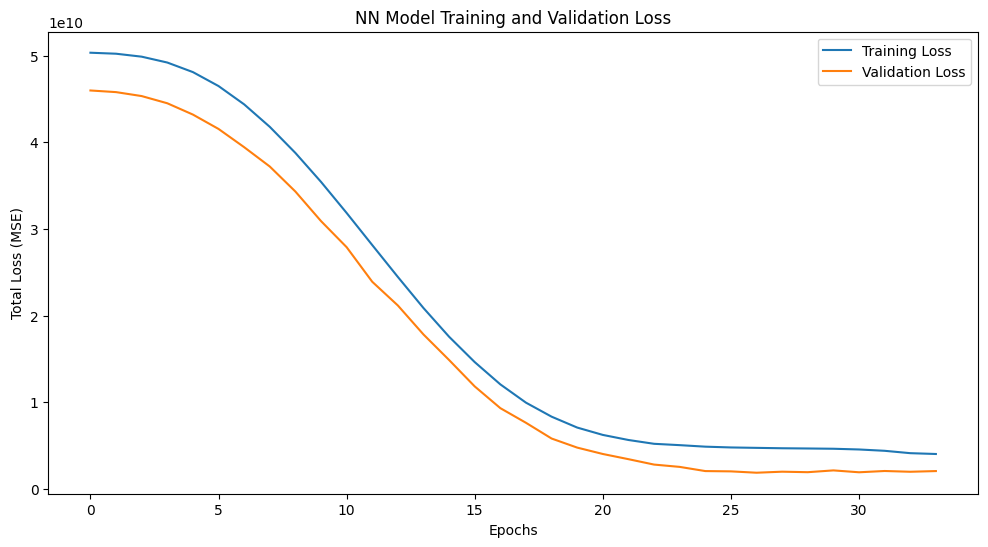

In [12]:
# %% [python]
# Plot training & validation loss
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 6))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('NN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Total Loss (MSE)')
plt.legend()
plt.savefig("nn_loss_plot.png")
print("Saved nn_loss_plot.png")

Saved nn_mae_plots.png


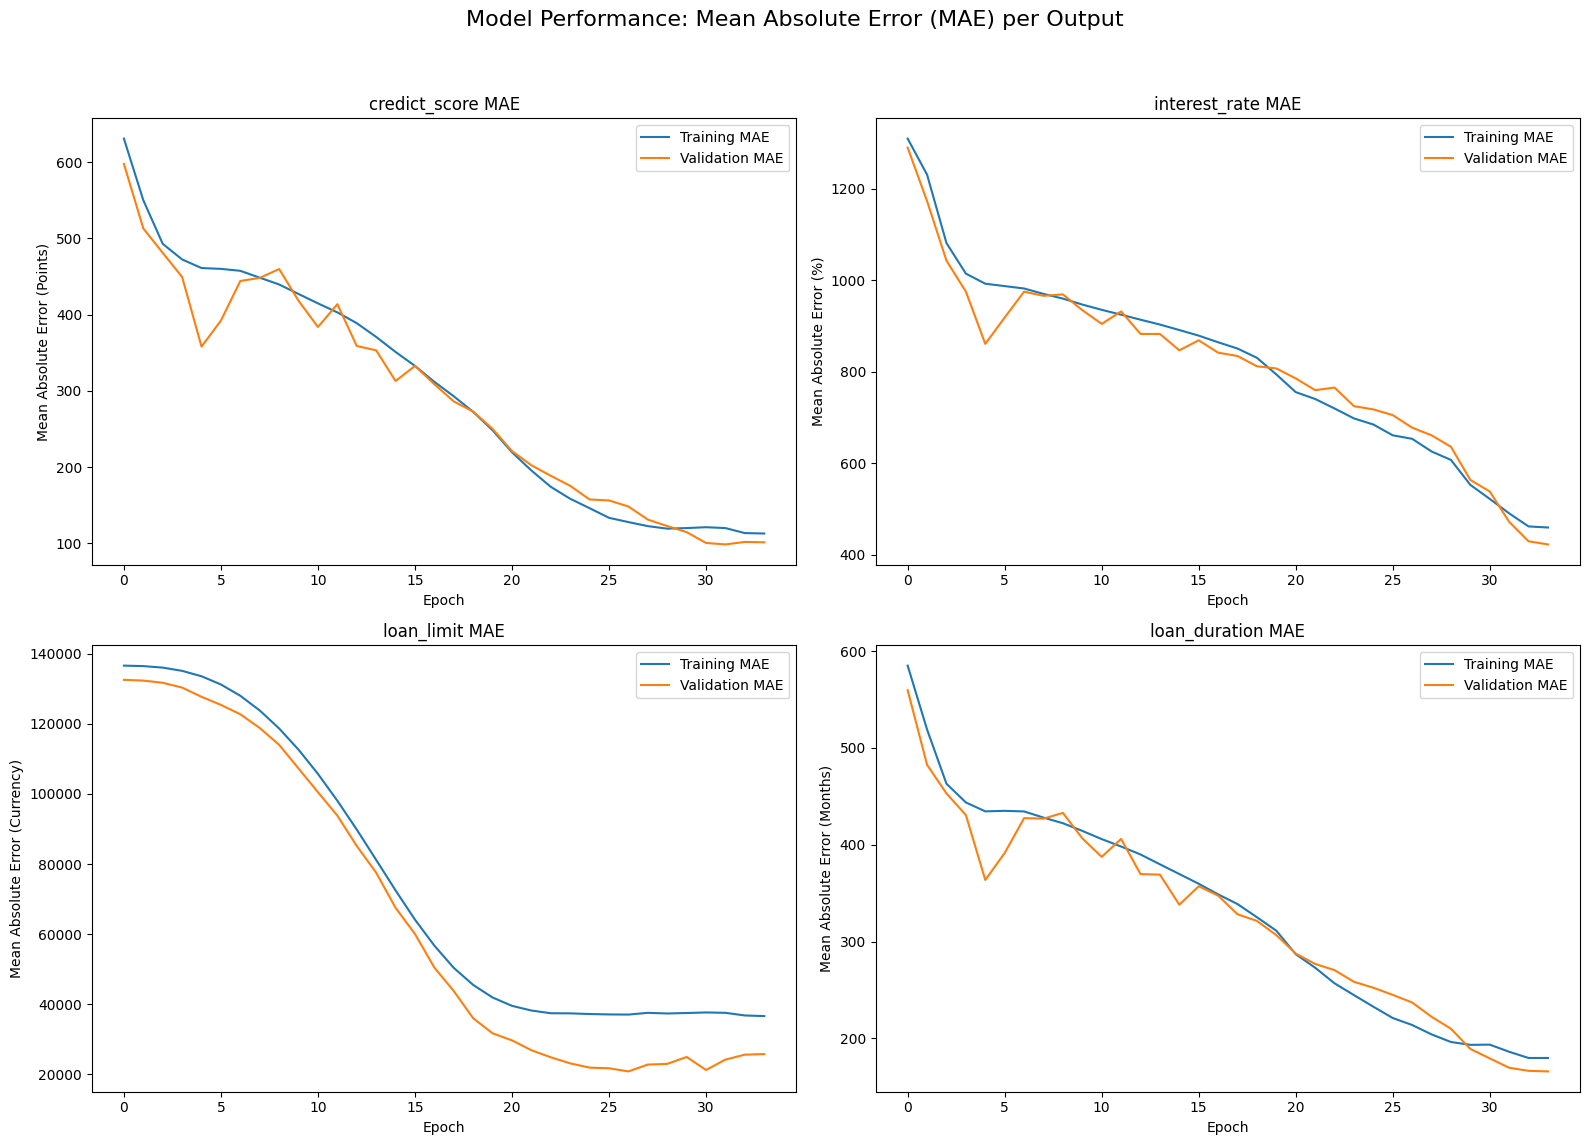

In [13]:
# %% [markdown]
# # . Plot Model Performance (Mean Absolute Error)
# 
# "Accuracy" is a metric for classification. For our regression task,
# "Mean Absolute Error" (MAE) is the best equivalent. This shows us
# the average error (in the target's units) for our predictions.
# 
# Lower MAE is better.

# %% [python]
import matplotlib.pyplot as plt

# The 'history' object from model.fit() contains our metrics
history_df = pd.DataFrame(history.history)

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance: Mean Absolute Error (MAE) per Output', fontsize=16)

# Plot 1: Credit Score MAE
axes[0, 0].plot(history_df['credict_score_mae'], label='Training MAE')
axes[0, 0].plot(history_df['val_credict_score_mae'], label='Validation MAE')
axes[0, 0].set_title('credict_score MAE')
axes[0, 0].set_ylabel('Mean Absolute Error (Points)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()

# Plot 2: Interest Rate MAE
axes[0, 1].plot(history_df['interest_rate_mae'], label='Training MAE')
axes[0, 1].plot(history_df['val_interest_rate_mae'], label='Validation MAE')
axes[0, 1].set_title('interest_rate MAE')
axes[0, 1].set_ylabel('Mean Absolute Error (%)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()

# Plot 3: Loan Limit MAE
axes[1, 0].plot(history_df['loan_limit_mae'], label='Training MAE')
axes[1, 0].plot(history_df['val_loan_limit_mae'], label='Validation MAE')
axes[1, 0].set_title('loan_limit MAE')
axes[1, 0].set_ylabel('Mean Absolute Error (Currency)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# Plot 4: Loan Duration MAE
axes[1, 1].plot(history_df['loan_duration_mae'], label='Training MAE')
axes[1, 1].plot(history_df['val_loan_duration_mae'], label='Validation MAE')
axes[1, 1].set_title('loan_duration MAE')
axes[1, 1].set_ylabel('Mean Absolute Error (Months)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

# Save the figure, just like the loss plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.savefig("nn_mae_plots.png")
print("Saved nn_mae_plots.png")

In [14]:
# Evaluate on the *unseen test data*
print("\n--- Neural Network Evaluation on Test Set ---")
test_metrics = nn_model.evaluate(X_test_processed, y_test_list, return_dict=True)
print("\nTest Set Metrics (Raw):")
print(test_metrics)

# Make predictions on the test set
y_pred_list = nn_model.predict(X_test_processed)
y_pred_df = pd.DataFrame({
    'credict_score': y_pred_list[0].flatten(),
    'interest_rate': y_pred_list[1].flatten(),
    'loan_limit': y_pred_list[2].flatten(),
    'loan_duration': y_pred_list[3].flatten()
}, index=y_test.index)

# Calculate R-squared (R2) for each target
# R2 = 1.0 is a perfect model. R2 = 0.0 is no better than guessing the mean.
print("\nTest Set R-squared (1.0 is perfect):")
for i, col in enumerate(target_cols):
    r2 = r2_score(y_test[col], y_pred_df[col])
    print(f"  {col}: {r2:.3f}")

print("\nSample Predictions vs Actual:")
print(pd.concat([y_test.head(5), y_pred_df.head(5)], axis=1, keys=['Actual', 'Predicted']))



--- Neural Network Evaluation on Test Set ---
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - credict_score_loss: 93469.3203 - credict_score_mae: 145.2569 - interest_rate_loss: 990864.8125 - interest_rate_mae: 675.9025 - loan_duration_loss: 162254.4688 - loan_duration_mae: 229.9963 - loan_limit_loss: 2147103360.0000 - loan_limit_mae: 21705.8633 - loss: 2162522880.0000 

Test Set Metrics (Raw):
{'credict_score_loss': 93469.3203125, 'credict_score_mae': 145.25694274902344, 'interest_rate_loss': 990864.8125, 'interest_rate_mae': 675.9025268554688, 'loan_duration_loss': 162254.46875, 'loan_duration_mae': 229.99627685546875, 'loan_limit_loss': 2147103360.0, 'loan_limit_mae': 21705.86328125, 'loss': 2162522880.0}
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Test Set R-squared (1.0 is perfect):
  credict_score: -9.763
  interest_rate: -19.361
  loan_limit: 0.932
  loan_duration: -3.514

Sample Predictions vs Actual:
            Actual                                            Predicted  \
     credic

In [15]:
# %% [markdown]
# # 8.1. Save the Trained Neural Network
# 
# We will save the final trained model (`nn_model`) to a file.
# The `.keras` format is the modern, standard way to save a TensorFlow model.

# %% [python]
print("Saving model...")

# Define the file path for the saved model
MODEL_FILE_PATH = 'multi_head_nn.keras'

try:
    # Save the entire model
    nn_model.save(MODEL_FILE_PATH)
    print(f"Successfully saved model to: {MODEL_FILE_PATH}")

except Exception as e:
    print(f"An error occurred while saving the model: {e}")

# We also need to save the preprocessor, as it's
# essential for making predictions on new, raw data.
import pickle

PREPROCESSOR_FILE_PATH = 'data_preprocessor.pkl'

try:
    with open(PREPROCESSOR_FILE_PATH, 'wb') as f:
        pickle.dump(preprocessor, f)
    print(f"Successfully saved preprocessor to: {PREPROCESSOR_FILE_PATH}")
except Exception as e:
    print(f"An error occurred while saving the preprocessor: {e}")

Saving model...
Successfully saved model to: multi_head_nn.keras
Successfully saved preprocessor to: data_preprocessor.pkl


In [16]:
# %% [markdown]
# # 8.2. Load Model and Run Inference
# 
# This cell demonstrates how to load the saved model and preprocessor
# to make predictions on new, unseen data.

# %% [python]
import tensorflow as tf
import pickle
import pandas as pd
import numpy as np

# --- 1. Load the Model and Preprocessor ---
print("Loading model and preprocessor...")

try:
    # Load the Keras model
    loaded_model = tf.keras.models.load_model('multi_head_nn.keras')
    
    # Load the preprocessor
    with open('data_preprocessor.pkl', 'rb') as f:
        loaded_preprocessor = pickle.load(f)
    
    print("Model and preprocessor loaded successfully.")

except Exception as e:
    print(f"Error loading files: {e}")


# --- 2. Get a Sample of New, Raw Data ---
# We'll take one row from our original test set (X_test)
# This is "raw" data *before* it was processed.
try:
    new_data_sample_df = X_test.iloc[[0]]
    print("\n--- New Raw Data Sample ---")
    print(new_data_sample_df)

    # --- 3. Preprocess the New Data ---
    # The preprocessor expects a 2D array or DataFrame
    new_data_processed = loaded_preprocessor.transform(new_data_sample_df)
    
    print("\nProcessed data shape:", new_data_processed.shape)
    
    # --- 4. Make a Prediction ---
    prediction_list = loaded_model.predict(new_data_processed)
    
    print("\n--- Model Prediction ---")
    
    # The model outputs a list of 4 arrays. Let's make it readable.
    pred_credict_score = prediction_list[0][0][0]
    pred_interest_rate = prediction_list[1][0][0]
    pred_loan_limit = prediction_list[2][0][0]
    pred_loan_duration = prediction_list[3][0][0]
    
    print(f"  Predicted Credit Score: {pred_credict_score:.2f}")
    print(f"  Predicted Interest Rate: {pred_interest_rate:.2f}%")
    print(f"  Predicted Loan Limit: ${pred_loan_limit:,.2f}")
    print(f"  Predicted Loan Duration: {pred_loan_duration:.2f} months")
    
    
    print("\n--- Actual Values (for comparison) ---")
    actual_values = y_test.iloc[[0]]
    print(actual_values)

except Exception as e:
    print(f"\nAn error occurred during inference: {e}")

Loading model and preprocessor...
Model and preprocessor loaded successfully.

--- New Raw Data Sample ---
      NDVI  avg_rainfall  avg_temp crop_type  price_of_crop  farm_size_sqm  \
6252  0.53           554      18.5    Coffee            250           1573   

      previous_loans_count  defaulted_loans_count  crop_yield_per_sqm  \
6252                     1                      0                1.09   

      total_yield_ksh  ...  profit_margin  expense_ratio  yield_value_per_sqm  \
6252         428642.5  ...       0.753468       0.246532                272.5   

      expense_per_sqm  default_rate  latitude  longitude  ndvi_x_rainfall  \
6252        67.179911           0.0 -1.561463    34.7751           293.62   

      temp_x_rainfall  price_x_yield  
6252          10249.0          272.5  

[1 rows x 22 columns]

Processed data shape: (1, 33)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

--- Model Prediction ---
  Predicted Credit Score: 580.40
  Predicted Interest Rate: 1056.69%
  Pre

# %% [markdown]
# # 9. SHAP Explainability (Neural Network)
# 
# We use `shap.DeepExplainer` to understand *why* the neural network is making its predictions.
# This explains the impact of each feature on each of the four outputs.

In [17]:
# %% [markdown]
# # 9a. Calculate SHAP Values (The Slow Part)
# 
# This cell runs the slow `KernelExplainer`. It will run for
# 50 samples and then save the results (`shap_values` and
# `X_test_subset_df`) in memory for the next cell to use.
# 
# **Run this cell only ONCE.**

# %% [python]
import warnings
print("\n--- Generating SHAP values for Neural Network (Using KernelExplainer) ---")
print("This will be slow, but it is the only method that is working.")

# We will only explain 50 samples. This is faster.
N_SAMPLES_TO_EXPLAIN = 50

# 1. Create a background summary dataset for KernelExplainer
print("Summarizing background data for KernelExplainer...")
# Supress warnings from kmeans
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    background_sample = shap.sample(X_train_processed, min(500, X_test_processed.shape[0]))
    background_data_summary = shap.kmeans(background_sample, 50)
print("...Background summary complete.")

# 2. Get the list of output names from the model
output_names = nn_model.output_names

# 3. Create a list to hold the shap values for each head
shap_values_list = []

# 4. Create the subset of data we will *actually* explain
X_test_subset = X_test_processed[:N_SAMPLES_TO_EXPLAIN]
print(f"Explaining the first {N_SAMPLES_TO_EXPLAIN} samples from the test set...")

# 5. Loop through each output head, one by one
for i, output_name in enumerate(output_names):
    print(f"Calculating SHAP values for output: {output_name} ({i+1}/{len(output_names)})...")
    
    # Create a new, single-output sub-model
    sub_model = Model(inputs=nn_model.inputs, outputs=nn_model.outputs[i])
    
    # KernelExplainer needs a prediction FUNCTION
    def predict_fn(x):
        return sub_model.predict(x).flatten()
    
    # Create the explainer
    explainer = shap.KernelExplainer(predict_fn, background_data_summary)
    
    # Calculate SHAP values on the *subset*
    shap_values_head = explainer.shap_values(X_test_subset[:50])
    
    # Add this array of SHAP values to our list
    shap_values_list.append(shap_values_head)

print("...SHAP value calculation complete.")

# For compatibility with the rest of the code, we rename our list
shap_values = shap_values_list

# Create the plotting DataFrame from the *same subset*
X_test_subset_df = pd.DataFrame(X_test_subset, columns=feature_names)

print("\n--- CALCULATION FINISHED ---")
print(f"Shape of SHAP values (head 1): {shap_values[0].shape}") 
print(f"Shape of plotting data: {X_test_subset_df.shape}")
print("You can now run the next cell to plot the results.")


--- Generating SHAP values for Neural Network (Using KernelExplainer) ---
This will be slow, but it is the only method that is working.
Summarizing background data for KernelExplainer...
...Background summary complete.
Explaining the first 50 samples from the test set...
Calculating SHAP values for output: credict_score (1/4)...
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step

2025-10-30 14:21:40.726379: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 14:21:41.665057: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_57', 28 bytes spill stores, 28 bytes spill loads

2025-10-30 14:21:41.770957: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_57', 24 bytes spill stores, 24 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step  


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
1/1 ━━━━━━━━━━━━━━━

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3288/3288 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

--- Plotting SHAP Values ---
Using shap_values (e.g., shape (50, 33)) and data (shape (50, 33))
Plotting SHAP for credict_score...


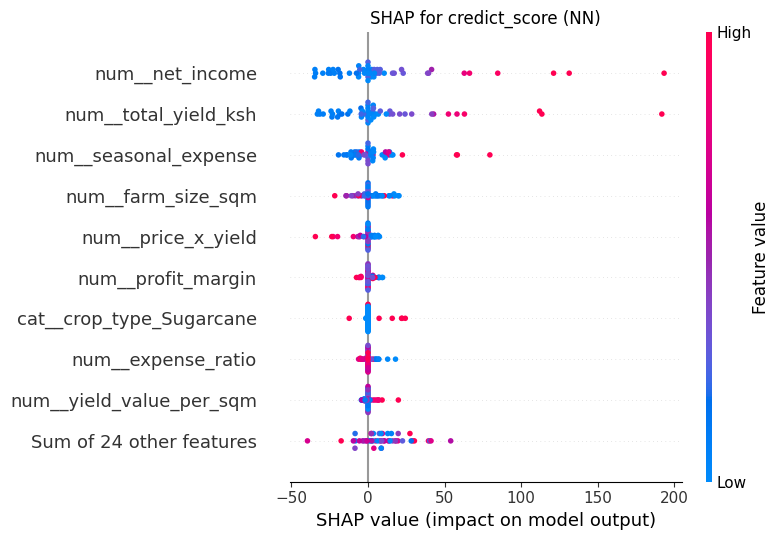

Saved shap_nn_1_credit_score.png
Plotting SHAP for interest_rate...


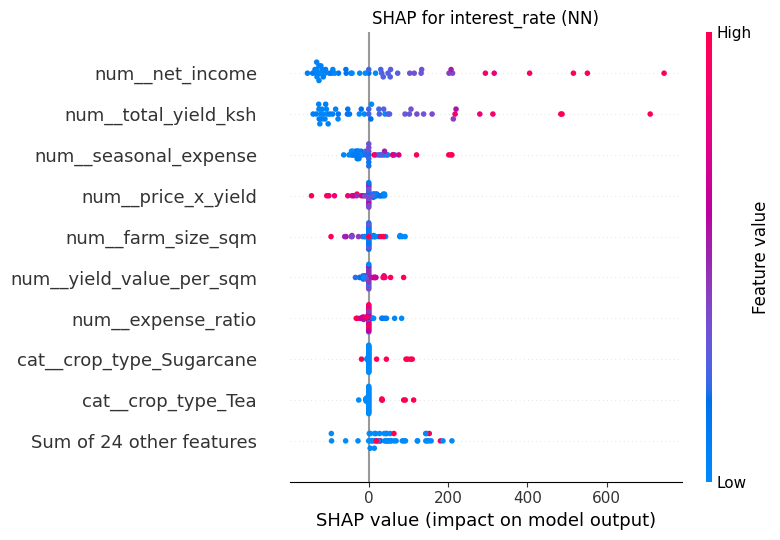

Saved shap_nn_2_interest_rate.png
Plotting SHAP for loan_limit...


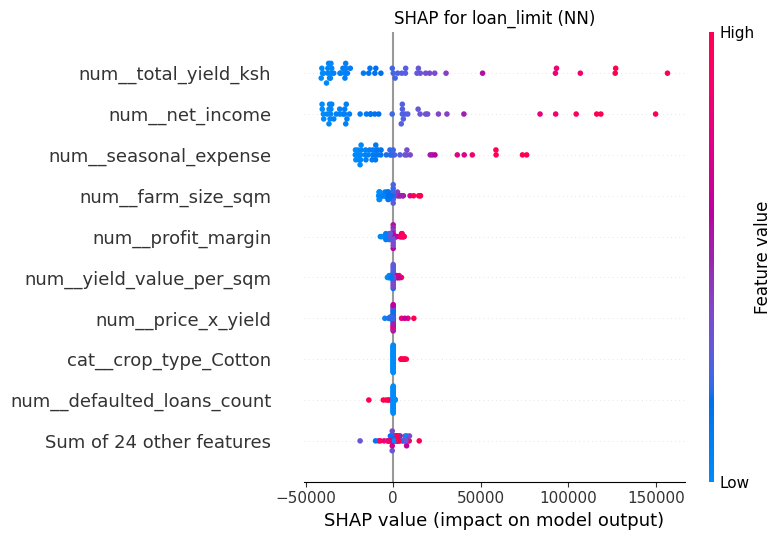

Saved shap_nn_3_loan_limit.png
Plotting SHAP for loan_duration...


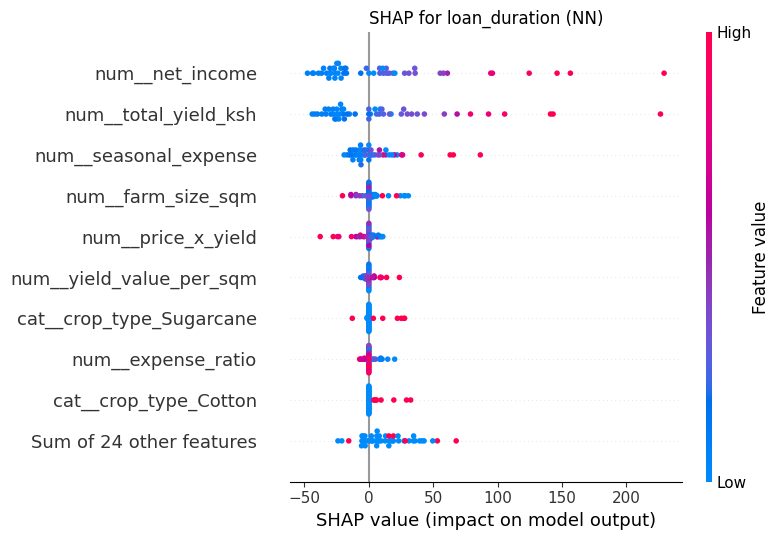

Saved shap_nn_4_loan_duration.png

All SHAP plots saved and displayed successfully.


In [18]:
# %% [markdown]
# # 9b. Plot SHAP Values (The Fast Part)
# 
# This cell uses the variables created by the cell above
# (`shap_values` and `X_test_subset_df`) to generate the plots.
# 
# **This version will save AND display the plots.**

# %% [python]
print("--- Plotting SHAP Values ---")
print(f"Using shap_values (e.g., shape {shap_values[0].shape}) and data (shape {X_test_subset_df.shape})")

try:
    # Target 1: credict_score
    print("Plotting SHAP for credict_score...")
    plt.figure()
    exp1 = shap.Explanation(
        values=shap_values[0], 
        data=X_test_subset_df 
    )
    shap.plots.beeswarm(exp1, show=False) 
    plt.title('SHAP for credict_score (NN)')
    plt.tight_layout()
    plt.savefig("shap_nn_1_credit_score.png")
    plt.show() # <-- ADDED THIS to display the plot
    print("Saved shap_nn_1_credit_score.png")
    
    # Target 2: interest_rate
    print("Plotting SHAP for interest_rate...")
    plt.figure()
    exp2 = shap.Explanation(
        values=shap_values[1], 
        data=X_test_subset_df
    )
    shap.plots.beeswarm(exp2, show=False)
    plt.title('SHAP for interest_rate (NN)')
    plt.tight_layout()
    plt.savefig("shap_nn_2_interest_rate.png")
    plt.show() # <-- ADDED THIS to display the plot
    print("Saved shap_nn_2_interest_rate.png")
    
    # Target 3: loan_limit
    print("Plotting SHAP for loan_limit...")
    plt.figure()
    exp3 = shap.Explanation(
        values=shap_values[2], 
        data=X_test_subset_df
    )
    shap.plots.beeswarm(exp3, show=False)
    plt.title('SHAP for loan_limit (NN)')
    plt.tight_layout()
    plt.savefig("shap_nn_3_loan_limit.png")
    plt.show() # <-- ADDED THIS to display the plot
    print("Saved shap_nn_3_loan_limit.png")
    
    # Target 4: loan_duration
    print("Plotting SHAP for loan_duration...")
    plt.figure()
    exp4 = shap.Explanation(
        values=shap_values[3], 
        data=X_test_subset_df
    )
    shap.plots.beeswarm(exp4, show=False)
    plt.title('SHAP for loan_duration (NN)')
    plt.tight_layout()
    plt.savefig("shap_nn_4_loan_duration.png")
    plt.show() # <-- ADDED THIS to display the plot
    print("Saved shap_nn_4_loan_duration.png")
    
    print("\nAll SHAP plots saved and displayed successfully.")

except Exception as e:
    print("\n--- AN ERROR OCCURRED DURING PLOTTING ---")
    print(f"Error Type: {type(e)}")
    print(f"Error Message: {e}")